In [1]:
import tensorflow as tf
import keras_tuner
from keras import Sequential, Model
from keras.utils import plot_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, Activation, Rescaling
from keras.callbacks import ModelCheckpoint, EarlyStopping

def build_model(hp):
    model = Sequential()
    model.add(InputLayer(input_shape=(128,128,1))), ## 390, 270
    model.add(Rescaling(1. / 255)),
    model.add(Conv2D(filters=32,kernel_size=(3,3),padding="valid", activation="relu")),
    model.add(Conv2D(filters=32,kernel_size=(3,3),padding="valid", activation="relu")),
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2))),
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding="valid", activation="relu")),
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding="valid", activation="relu")),
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2))),
    model.add(Conv2D(filters=16, kernel_size=(3,3), padding="valid", activation="relu")),
    model.add(Conv2D(filters=16, kernel_size=(3,3), padding="valid", activation="relu")),
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2))),
    model.add(Conv2D(filters=16, kernel_size=(3,3), padding="valid", activation="relu")),
    model.add(Conv2D(filters=16, kernel_size=(3,3), padding="valid", activation="relu")),
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2))),
    model.add(Flatten())
    model.add(Dense(units=256,activation="relu"))
    model.add(Dense(units=hp.Int("units", min_value=128, max_value=512, step=128), activation="relu"))
    model.add(Dense(10, activation="softmax"))

    hp_optimizer = hp.Choice('optimizer', values=['adam', 'SGD', 'rmsprop'])
    optimizer = tf.keras.optimizers.get(hp_optimizer)

    optimizer.learning_rate = hp.Choice("learning_rate", [0.001])

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"],)

    return model

build_model(keras_tuner.HyperParameters())

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=10,
    directory=r"C:\Users\NAS\Desktop\spectrograms",
    project_name="keras_trial",
)

tuner.search_space_summary()

Found 8732 files belonging to 10 classes.
Using 6986 files for training.
Found 8732 files belonging to 10 classes.
Using 1746 files for validation.
 
Batches for training --> tf.Tensor(219, shape=(), dtype=int64)
 
Batches for validating --> tf.Tensor(40, shape=(), dtype=int64)
 
Batches for testing --> tf.Tensor(15, shape=(), dtype=int64)
Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 128, 'sampling': None}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'SGD', 'rmsprop'], 'ordered': False}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001], 'ordered': True}


In [2]:
%run preprocessing.ipynb
train_ds, val_ds, test_dataset = data('C:\\Users\\Madao\\Desktop\\spectrograms', batch_size=32, image_size=(128,128), test_size=15, validation_split=.2)

tuner.search(train_ds, epochs=15, validation_data=val_ds)

Trial 10 Complete [00h 04m 53s]
val_accuracy: 0.8009478449821472

Best val_accuracy So Far: 0.8285939693450928
Total elapsed time: 00h 45m 42s
INFO:tensorflow:Oracle triggered exit


In [4]:
models = tuner.get_best_models(num_models=1)[0]

models.build(input_shape=(128, 128))
models.summary()

tuner.results_summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 58, 32)        9248      
                                                        

In [7]:
checkpoint = ModelCheckpoint("model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='auto') ## Save best model

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='auto') ## Epoch and Accuracy Optimization

best_hps = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_ds, validation_data= val_ds, epochs=30, callbacks=[checkpoint, early])

Epoch 1/30
218/219 [============================>.] - ETA: 0s - loss: 1.7563 - accuracy: 0.3561
Epoch 1: val_accuracy improved from -inf to 0.49842, saving model to model.h5
219/219 [==============================] - 16s 66ms/step - loss: 1.7563 - accuracy: 0.3563 - val_loss: 1.3765 - val_accuracy: 0.4984
Epoch 2/30
218/219 [============================>.] - ETA: 0s - loss: 1.2356 - accuracy: 0.5636
Epoch 2: val_accuracy improved from 0.49842 to 0.57820, saving model to model.h5
219/219 [==============================] - 15s 67ms/step - loss: 1.2352 - accuracy: 0.5637 - val_loss: 1.1480 - val_accuracy: 0.5782
Epoch 3/30
218/219 [============================>.] - ETA: 0s - loss: 1.0017 - accuracy: 0.6530
Epoch 3: val_accuracy did not improve from 0.57820
219/219 [==============================] - 15s 69ms/step - loss: 1.0026 - accuracy: 0.6527 - val_loss: 1.8448 - val_accuracy: 0.4597
Epoch 4/30
218/219 [============================>.] - ETA: 0s - loss: 0.8432 - accuracy: 0.7070
Epoch 4

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


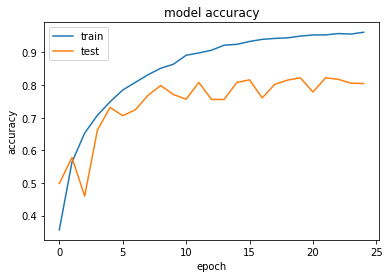

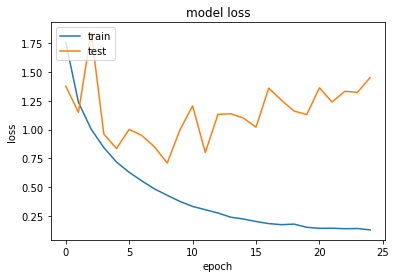

In [8]:
import matplotlib.pyplot as plt

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
eval_result = model.evaluate(test_dataset)
print("[test loss, test accuracy]:", eval_result)

15/15 [==============================] - 1s 25ms/step - loss: 1.0061 - accuracy: 0.8333
[test loss, test accuracy]: [1.00612211227417, 0.8333333134651184]
